<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/Tutorial4_(Synaptic%2C_Alpha).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# If you care for the precise timing of a spike, it seems easier to control that for a 2nd-order neuron. 
# In the Leaky model, a spike would be triggered in direct synchrony with the input. 
# For 2nd-order models, the membrane potential is 'smoothed out' (i.e., the synaptic current model low-pass filters the membrane potential),
#  which means U[t] experiences a finite rise time. 
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [90]:
#@title Plotting Settings

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)     #    alpha=0.25: brightness of the line
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()


  Spikes are all summed together. Synaptic current (Isyn), is then integrated by the passive membrane equation, thus generating output spikes.



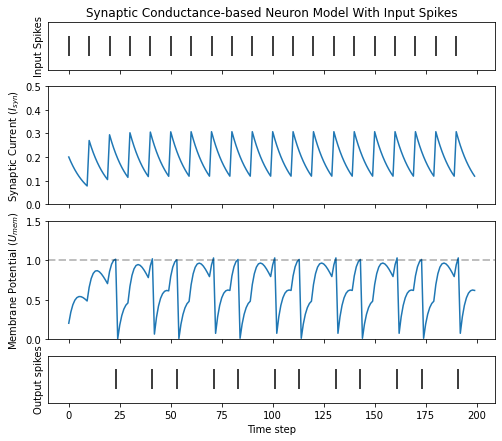

In [91]:
#---------------------------------------- 1. Synaptic Conductance-based LIF Neuron Model -------------------------------------

# In reality, a spike will result in the gradual release of neurotransmitters from the pre-synaptic neuron to the post-synaptic neuron. 
# The synaptic conductance-based LIF model accounts for the gradual temporal dynamics of input current.

# AMPA-receptors respond extremely quickly, while NMDA receptors show a slow decay of post-synaptic current.
# α: the decay rate of the synaptic current,  β: the decay rate of the membrane potential (as with Lapicque)


# Temporal dynamics
alpha = 0.9     #   Synaptic current integrates input spikes and decays at arate of alpha
beta = 0.8       # Membrane potential integrates the synaptic current and decays at a rate of beta
num_steps = 200

# Initialize 2nd-order LIF neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)




#------------------------ Apply a periodic spiking input to see how current and membrane evolve with time:
#   The output spikes experience a delay with respect to the input spikes

# Periodic spiking input, spk_in = 0.2 
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1) 
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

print('')
print("  Spikes are all summed together. Synaptic current (Isyn), is then integrated by the passive membrane equation, thus generating output spikes.")
print('')
plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, 
                     "Synaptic Conductance-based Neuron Model With Input Spikes")



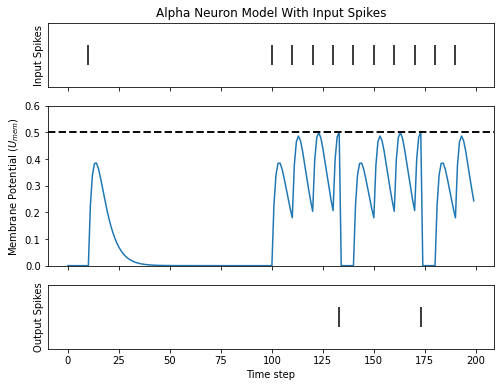

In [92]:
#---------------------------------------- 2. Alpha Neuron Model (Hacked Spike Response Model) -------------------------------------

# The Spike Response Model (SRM) family of models are interpreted in terms of a filter. 
# Upon the arrival of an input spike, this spike is convolved with the filter to give the membrane potential response. 


# As the membrane potential is now determined by the sum of two exponentials, each of these exponents has their own independent decay rate. 
# α defines the decay rate of the positive exponential, and β defines the decay rate of the negative exponential.
alpha = 0.8
beta = 0.7
# initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

# the sum of two exponential functions requires the synaptic current syn to be split into a syn_exc and syn_inh component:

# ------ Inputs:
# spk_in: each weighted input voltage spike WX[t] is sequentially passed in
# syn_exc: excitatory post-synaptic current Isyn−exc[t−1] at the previous time step
# syn_inh: inhibitory post-synaptic current Isyn−inh[t−1] at the previous time step
# mem: membrane potential Umem[t−1] at the present time t at the previous time step
 
# ------ Outputs:
# spk_out: output spike Sout[t] at the present time step ('1' if there is a spike; '0' if there is no spike)
# syn_exc: excitatory post-synaptic Isyn−exc[t] at the present time step t
# syn_inh: inhibitory post-synaptic current 
# Isyn−inh[t] at the present time step t 
# mem: membrane potential Umem[t] at the present time step


# input spike: initial spike, and then period spiking 
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89), (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")